# Part 2: Numerical Computations (Python Implementation)

## Required Packages & Call Option Data

In [ ]:
import numpy as np
import math
from scipy.optimize import minimize
from scipy.optimize import bisect
from scipy.optimize import root_scalar
from scipy.interpolate import CubicSpline
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.integrate import quad

def black_scholes_call(F, K, T, sigma):
    """Black-Scholes price for a call option given forward F, strike K, expiry T, and implied vol sigma."""
    d1 = (np.log(F / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = F * norm.cdf(d1) - K * norm.cdf(d2)
    return price

def implied_vol(F, K, T, price):
    def obj(sigma):
        return black_scholes_call(F, K, T, sigma) - price
    result = root_scalar(obj, bracket=[-5, 5.0], method='brentq')
    return result.root if result.converged else np.nan

T=1/12

#EUR/USD call prices (strikes against observed implied volatilities)
X_strikes = np.array([1.0681,1.0791,1.0904,1.1014,1.1119])
X_market_vols = np.array([0.0554,0.053115,0.0516,0.051435,0.0523])
X_forw=1.0903

X_norm=X_strikes/X_forw
X_strikes_lognrm = np.log(X_norm)
X_market_prices=np.zeros(len(X_strikes))
for i in range(len(X_strikes)):
    X_market_prices[i]=black_scholes_call(X_forw, X_strikes[i], T, X_market_vols[i])

#GBP/USD call prices (strikes against observed implied volatilities)
Y_strikes = np.array([1.2456,1.2595,1.274,1.2883,1.3017])
Y_market_vols = np.array([0.06055,0.058665,0.0573,0.057185,0.05765])
Y_forw=1.2738
Y_norm=Y_strikes/Y_forw
Y_strikes_lognrm = np.log(Y_norm)
Y_market_prices=np.zeros(len(Y_strikes))
for i in range(len(Y_strikes)):
    Y_market_prices[i]=black_scholes_call(Y_forw, Y_strikes[i], T, Y_market_vols[i])

#EUR/GBP call prices (strikes against observed implied volatilities)
Z_strikes = np.array([0.84386,0.84969,0.85585,0.86234,0.86875])
Z_market_vols = np.array([0.03809,0.03725,0.037225,0.03825,0.03986])
Z_forw=0.8559
Z_norm=Z_strikes/Z_forw
Z_strikes_lognrm = np.log(Z_norm)
Z_market_prices=np.zeros(len(Z_strikes))
for i in range(len(Z_strikes)):
    Z_market_prices[i]=black_scholes_call(Z_forw, Z_strikes[i], T, Z_market_vols[i])

In [21]:
#testing that the B-S pricing and vol functions work
def test_black_scholes_inversion():
    # EUR/USD
    for i in range(len(X_strikes)):
        price = black_scholes_call(X_forw, X_strikes[i], T, X_market_vols[i])
        iv = implied_vol(X_forw, X_strikes[i], T, price)
        assert abs(iv - X_market_vols[i]) < 1e-8, f"EUR/USD failed at {i}: {iv} vs {X_market_vols[i]}"
    # GBP/USD
    for i in range(len(Y_strikes)):
        price = black_scholes_call(Y_forw, Y_strikes[i], T, Y_market_vols[i])
        iv = implied_vol(Y_forw, Y_strikes[i], T, price)
        assert abs(iv - Y_market_vols[i]) < 1e-8, f"GBP/USD failed at {i}: {iv} vs {Y_market_vols[i]}"
    # EUR/GBP
    for i in range(len(Z_strikes)):
        price = black_scholes_call(Z_forw, Z_strikes[i], T, Z_market_vols[i])
        iv = implied_vol(Z_forw, Z_strikes[i], T, price)
        assert abs(iv - Z_market_vols[i]) < 1e-8, f"EUR/GBP failed at {i}: {iv} vs {Z_market_vols[i]}"
    print("All Black-Scholes inversion tests passed.")

# Run the test
test_black_scholes_inversion()

All Black-Scholes inversion tests passed.


# Part 1: Fitting an SVI curve to the data
## Curve fitting code

In [22]:
#all the below accepts the strike in log norm form!
def svi_var(k_lognrm,params):
    """
    k: array of strikes (log-normalised)
    a: base level of volatility
    b: slope
    sigma: curvature
    rho: skewness
    m: location of minimum volatility
    """
    a, b, sigma, rho, m = params[0], params[1], params[2], params[3], params[4]
    rho=min(max(rho,-1.0),1.0)
    b=min(b,2/(1+np.abs(rho)))
    a=max(a,-b*sigma*np.sqrt(1-rho**2))
    x=k_lognrm
    return a + b * (rho * (x - m) + np.sqrt((x - m)**2 + sigma**2))

def svi_vol(k_lognrm,params,T):
    return np.sqrt(svi_var(k_lognrm,params)/T)

def svi_rss(k_lognrm,params,obs_v):
    return np.sum((svi_vol(k_lognrm,params,T)-obs_v)**2)

def svi_fit(k_lognrm,obs_vars,bestp):
    #input strikes and market vols, return params for SVI smile
    
    params_init = bestp  # initial guess for [a, b, sigma, rho, m] {"a": 0.05125, "b": 0.09, "rho": -0.3, "m": 1.0975, "sigma": 0.001}
    
    def objective(params):
        return svi_rss(k_lognrm,params,obs_vars)
    
    result = minimize(
        fun=objective, 
        x0=params_init,
        method='Nelder-Mead', 
        tol=1E-14, 
        options={"maxiter":2000}
    )
    
    return result

## Resulting SVI curves

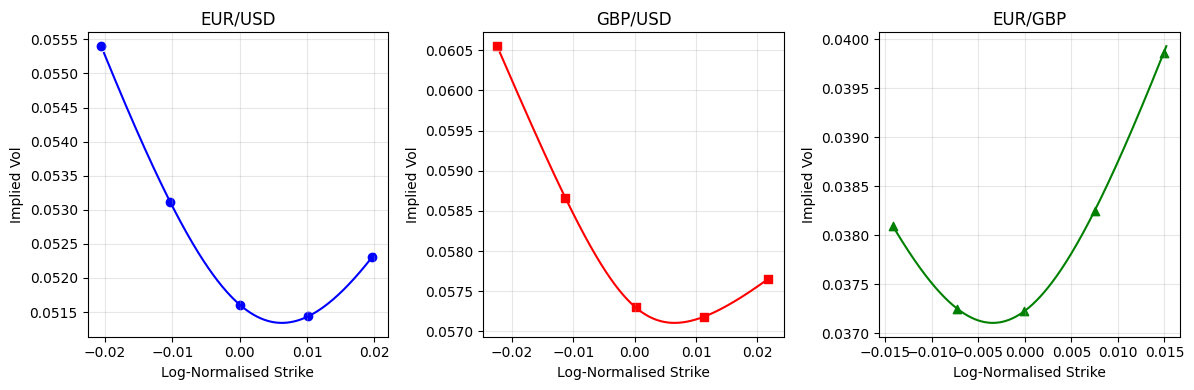

In [23]:
Xopt = svi_fit(X_strikes_lognrm,X_market_vols,[0.0001, 0.002, 0.0014, 0, 0.005])
Yopt = svi_fit(Y_strikes_lognrm,Y_market_vols,[0.0001, 0.002, 0.0014, 0, 0.005])
Zopt = svi_fit(Z_strikes_lognrm,Z_market_vols,[0.00001, 0.0005, 0.001, 0, 0.0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
X_strike_range = np.linspace(0.98*min(X_strikes_lognrm), 1.02*max(X_strikes_lognrm), 1000)
Y_strike_range = np.linspace(0.98*min(Y_strikes_lognrm), 1.02*max(Y_strikes_lognrm), 1000)
Z_strike_range = np.linspace(0.98*min(Z_strikes_lognrm), 1.02*max(Z_strikes_lognrm), 1000)

ax1.scatter(X_strikes_lognrm, X_market_vols, label='Market Data', color='blue', marker='o')
ax1.plot(X_strike_range, svi_vol(X_strike_range, Xopt.x,T), 'b-', label='SVI Fit')
ax1.set_title('EUR/USD')
ax1.set_ylabel('Implied Vol')
ax1.set_xlabel('Log-Normalised Strike')
ax1.grid(True, alpha=0.3)

ax2.scatter(Y_strikes_lognrm, Y_market_vols, label='Market Data', color='red', marker='s')
ax2.plot(Y_strike_range, svi_vol(Y_strike_range, Yopt.x,T), 'r-', label='SVI Fit')
ax2.set_title('GBP/USD')
ax2.set_xlabel('Log-Normalised Strike')
ax2.set_ylabel('Implied Vol')
ax2.grid(True, alpha=0.3)

ax3.scatter(Z_strikes_lognrm, Z_market_vols, label='Market Data', color='green', marker='^')
ax3.plot(Z_strike_range, svi_vol(Z_strike_range, Zopt.x,T), 'g-', label='SVI Fit')
ax3.set_title('EUR/GBP')
ax3.set_xlabel('Log-Normalised Strike')
ax3.set_ylabel('Implied Vol')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Derivation of the B-L Density for a given SVI smile using Sympy

In [5]:
#sympy to derive SVI formula
"""
import sympy



F, K, d1, d2  = symbols('F K d1 d2')
X = Normal('X', 0, 1)  #std normal var

callBS= F*cdf(X)(d1)-K*(d2)

svisig=
"""

"\nimport sympy\n\n\n\nF, K, d1, d2  = symbols('F K d1 d2')\nX = Normal('X', 0, 1)  #std normal var\n\ncallBS= F*cdf(X)(d1)-K*(d2)\n\nsvisig=\n"

### B-L Function implementation

In [6]:
def SVIDensity(K_norm,params):
    a=params[0];b=params[1];sigma=params[2];rho=params[3];m=params[4];
    k=np.log(K_norm)
    V=a + b*(rho*(k - m) + np.sqrt((k - m)**2 + sigma**2))
    V1=b*(rho + (k-m)/np.sqrt((m - k)**2 + sigma**2))
    V2=b*sigma**2/(m**2 - 2*m*k + k**2 + sigma**2)**1.5
    tmp=-np.exp(-(4*k**2 + V**2)/(8*V))
    tmp2=-4*k**2*V1**2 +4*V*V1*(4*k +V1) +  V**2*(V1**2 -8*(2 + V2))
    tmp3=16*K_norm**1.5*np.sqrt(2*math.pi)*V**2.5
    return tmp*tmp2/tmp3

#Construction of the reference densities from the SVI curves for X,Y,Z
def mu_X(xvar):
    return SVIDensity(xvar,Xopt.x)
def mu_Y(yvar):
    return SVIDensity(yvar,Yopt.x)
def mu_Z(zvar):
    return SVIDensity(zvar,Zopt.x)

### Plot of Densities and confirmation of integrals

### Testing Normalisation of densities via Gaussian Quadrature

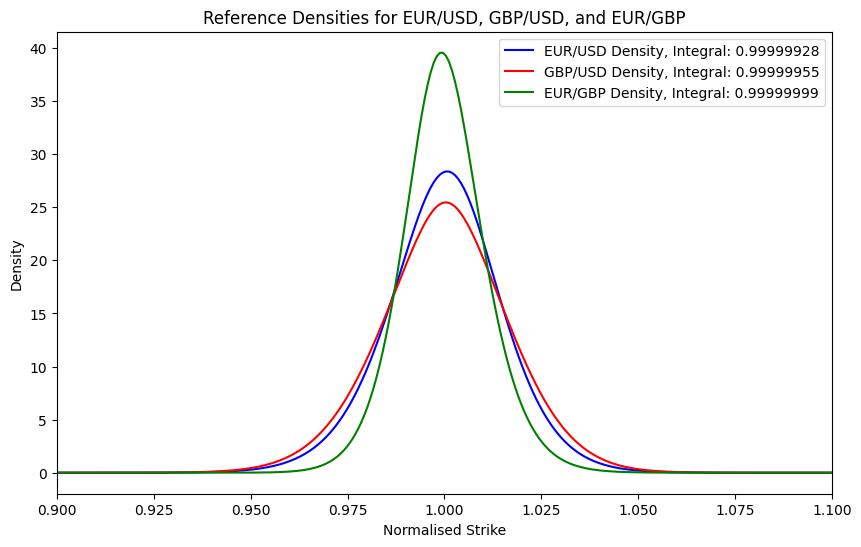

In [7]:
quadPoints = 400
[u, w] = np.polynomial.legendre.leggauss(quadPoints)
a = 0.9
b = 1.1
quadgrid = 0.5*(b-a)*u + 0.5*(a+b)
quadweights = 0.5*(b-a)*w

integral_X = np.sum(mu_X(quadgrid) * quadweights)
integral_Y = np.sum(mu_Y(quadgrid) * quadweights)
integral_Z = np.sum(mu_Z(quadgrid) * quadweights)

#plot mu_X. Y  Z densities with integral values of annotated
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(quadgrid, mu_X(quadgrid), label='EUR/USD Density, Integral: '+str(round(integral_X,8)), color='blue')
ax.plot(quadgrid, mu_Y(quadgrid), label='GBP/USD Density, Integral: '+str(round(integral_Y,8)), color='red')
ax.plot(quadgrid, mu_Z(quadgrid), label='EUR/GBP Density, Integral: '+str(round(integral_Z,8)), color='green')

ax.set_xlim(0.9, 1.1)
ax.set_title('Reference Densities for EUR/USD, GBP/USD, and EUR/GBP')
ax.set_xlabel('Normalised Strike')
ax.set_ylabel('Density')
ax.legend()
plt.show()

### Pricing Basic Call Options with the Reference Densities

#### Payoff function for a European call option

In [8]:
#Payoff function for a call option
simple_call=lambda x,k: np.maximum(0,x-k)

#Gaussian Quadrature to integrate payoff of an option with normalised strike 1 (i.e. an call with strike = Forward price)
density_price_X_atm = np.sum(simple_call(quadgrid, 1) * mu_X(quadgrid) * quadweights) * X_forw
market_price_X_atm = black_scholes_call(X_forw, X_forw, T, svi_vol(0, Xopt.x, T))

density_price_Y_atm = np.sum(simple_call(quadgrid, 1) * mu_Y(quadgrid) * quadweights) * Y_forw
market_price_Y_atm = black_scholes_call(Y_forw, Y_forw, T, svi_vol(0, Yopt.x, T))

density_price_Z_atm = np.sum(simple_call(quadgrid, 1) * mu_Z(quadgrid) * quadweights) * Z_forw
market_price_Z_atm = black_scholes_call(Z_forw, Z_forw, T, svi_vol(0, Zopt.x, T))

print("PRICE OF AT THE MONEY CALL USING REF DENSITIES")
print("++++++++++++++++++++++++++++++++++++++++++++++++")
print(f"{'Pair':<10} {'Density Price':>18} {'Market BS Price':>18} {'Difference':>12}")
print("-" * 60)
print(f"{'EUR/USD':<10} {density_price_X_atm:18.8f} {market_price_X_atm:18.8f} {(density_price_X_atm-market_price_X_atm):12.2e}")
print(f"{'GBP/USD':<10} {density_price_Y_atm:18.8f} {market_price_Y_atm:18.8f} {(density_price_Y_atm-market_price_Y_atm):12.2e}")
print(f"{'EUR/GBP':<10} {density_price_Z_atm:18.8f} {market_price_Z_atm:18.8f} {(density_price_Z_atm-market_price_Z_atm):12.2e}")

PRICE OF AT THE MONEY CALL USING REF DENSITIES
++++++++++++++++++++++++++++++++++++++++++++++++
Pair            Density Price    Market BS Price   Difference
------------------------------------------------------------
EUR/USD            0.00648080         0.00648003     7.74e-07
GBP/USD            0.00840797         0.00840715     8.24e-07
EUR/GBP            0.00367046         0.00366959     8.65e-07


### Test that pricing via densities agrees with market data

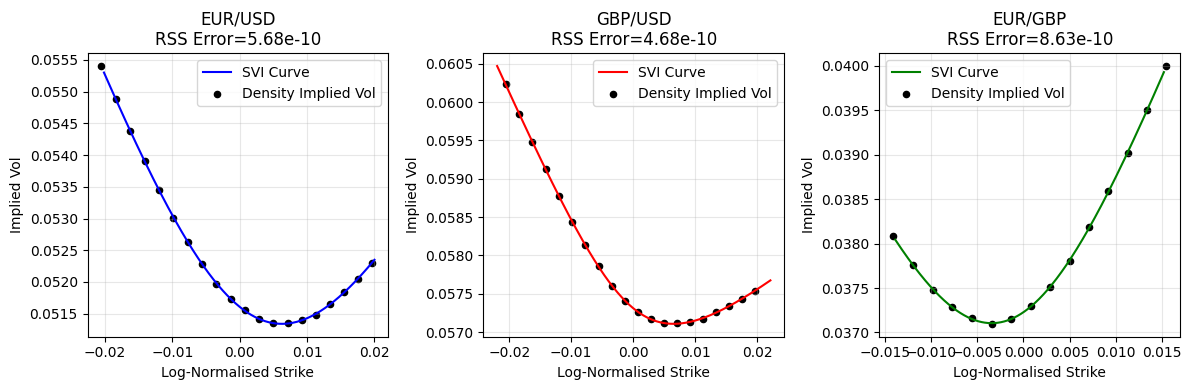

In [9]:
#Testing the desnities for X,Y,Z by pricing options at the observed strike and checking results match market data


strikes = np.linspace(X_norm[0],X_norm[-1],20)

density_price_X=np.zeros_like(strikes)
density_vol_X=np.zeros_like(strikes)
density_price_Y=np.zeros_like(strikes)
density_vol_Y=np.zeros_like(strikes)
density_price_Z=np.zeros_like(strikes)
density_vol_Z=np.zeros_like(strikes)



for i in range(len(strikes)):
    #Integration via GQ to price simple options on X,Y,Z
    density_price_X[i] = np.sum(simple_call(quadgrid,strikes[i])*mu_X(quadgrid) * quadweights)*X_forw
    density_price_Y[i] = np.sum(simple_call(quadgrid,strikes[i])*mu_Y(quadgrid) * quadweights)*Y_forw
    density_price_Z[i] = np.sum(simple_call(quadgrid,strikes[i])*mu_Z(quadgrid) * quadweights)*Z_forw

#Conversion from price to implied vol using BS for comparison against the market derived SVI
density_vol_X = [implied_vol(X_forw, strikes[i]*X_forw, T, density_price_X[i]) for i in range(len(strikes))]
density_vol_Y = [implied_vol(Y_forw, strikes[i]*Y_forw, T, density_price_Y[i]) for i in range(len(strikes))]
density_vol_Z = [implied_vol(Z_forw, strikes[i]*Z_forw, T, density_price_Z[i]) for i in range(len(strikes))]

# Plot: Implied vol from density price (scatter) vs SVI curve (line) with more density points
#proves that the pricing from the densities agrees with the MARKET DATA!!!

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Calculate SVI vol at the density-implied vol points
svi_vol_X_points = svi_vol(np.log(strikes), Xopt.x, T)
svi_vol_Y_points = svi_vol(np.log(strikes), Yopt.x, T)
svi_vol_Z_points = svi_vol(np.log(strikes), Zopt.x, T)

# Calculate RSS errors
rss_X = np.sum((np.array(density_vol_X) - svi_vol_X_points)**2)
rss_Y = np.sum((np.array(density_vol_Y) - svi_vol_Y_points)**2)
rss_Z = np.sum((np.array(density_vol_Z) - svi_vol_Z_points)**2)

# EUR/USD
ax1.plot(X_strike_range, svi_vol(X_strike_range, Xopt.x, T), 'b-', label='SVI Curve')
ax1.scatter(np.log(strikes), density_vol_X, label='Density Implied Vol', color='black', marker='o', s=20)
ax1.set_title(f'EUR/USD\nRSS Error={rss_X:.2e}')
ax1.set_ylabel('Implied Vol')
ax1.set_xlabel('Log-Normalised Strike')
ax1.grid(True, alpha=0.3)
ax1.legend()

# GBP/USD
ax2.plot(Y_strike_range, svi_vol(Y_strike_range, Yopt.x, T), 'r-', label='SVI Curve')
ax2.scatter(np.log(strikes), density_vol_Y, label='Density Implied Vol', color='black', marker='o', s=20)
ax2.set_title(f'GBP/USD\nRSS Error={rss_Y:.2e}')
ax2.set_xlabel('Log-Normalised Strike')
ax2.set_ylabel('Implied Vol')
ax2.grid(True, alpha=0.3)
ax2.legend()

# EUR/GBP
ax3.plot(Z_strike_range, svi_vol(Z_strike_range, Zopt.x, T), 'g-', label='SVI Curve')
ax3.scatter(np.log(strikes[3:-2]), density_vol_Z[3:-2], label='Density Implied Vol', color='black', marker='o', s=20)
# For RSS, use the same subset as plotted
rss_Z_plot = np.sum((np.array(density_vol_Z[3:-2]) - svi_vol_Z_points[3:-2])**2)
ax3.set_title(f'EUR/GBP\nRSS Error={rss_Z_plot:.2e}')
ax3.set_xlabel('Log-Normalised Strike')
ax3.set_ylabel('Implied Vol')
ax3.grid(True, alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.show()


# Task 2
Using the above densities as a reference we apply the sinkhorn algorithm to calibrate a joint density function.

In [10]:

def sinkhorn(quadgrid,quadweights,iterations=20):  
    u_x= np.zeros(len(quadgrid))
    v_y= np.zeros(len(quadgrid))
    w_z= np.zeros(len(quadgrid))
    x_points=quadgrid
    y_points=quadgrid
    z_points = np.linspace(np.min(x_points)/np.max(y_points), np.max(x_points)/np.min(y_points), len(quadgrid))
    for it in range(iterations):
        w_spline= CubicSpline(z_points, w_z)
        #u update
        for i in range(u_x.shape[0]):
            yw_z = y_points*w_spline(x_points[i]/y_points)
            intx=np.exp(np.clip(v_y+yw_z,-700,700))*mu_Y(y_points)
            u_x[i] = -np.log(np.sum(intx * quadweights)) 
        #v update
        for j in range(v_y.shape[0]):
            yw_z = y_points[j]*w_spline(x_points/y_points[j])
            inty=np.exp(np.clip(u_x+yw_z,-700,700))*mu_X(x_points)
            v_y[j] = -np.log(np.sum(inty * quadweights))
        #w update using bisection for w
        v_spline = CubicSpline(y_points, v_y)
        for k in range(len(z_points)):
            zk = z_points[k]
            def root_func(wz):
                x_over_z = x_points / zk
                exp_term = u_x + v_spline(x_over_z) + x_over_z * wz
                exp_term_clipped = np.clip(exp_term, -700, 700)
                intz = np.exp(exp_term_clipped) * (x_points**2 / zk**3) * mu_X(x_points) * mu_Y(x_points/zk)
                return np.sum(intz * quadweights) - mu_Z(zk)
            w_z[k] = bisect(root_func, -5000, 100,rtol=1e-4)
    return u_x, v_y, w_z

def opt_mu(x,y, u_spline, v_spline, w_spline):
    return np.exp(u_spline(x)+v_spline(y)+y*w_spline(x/y))*mu_X(x)*mu_Y(y)

In [11]:
#Example usage with normalisation checks
sinkPoints = 400
[u_s, w_s] = np.polynomial.legendre.leggauss(sinkPoints)
a_s = 0.8
b_s = 1.2
sinkgrid = 0.5*(b_s-a_s)*u_s + 0.5*(a_s+b_s)
sinkweights = 0.5*(b_s-a_s)*w_s

opt_u, opt_v, opt_w = sinkhorn(sinkgrid, sinkweights, 20)
z_points = np.linspace(np.min(sinkgrid)/np.max(sinkgrid), np.max(sinkgrid)/np.min(sinkgrid), len(sinkgrid))

u_spline = CubicSpline(sinkgrid, opt_u)
v_spline = CubicSpline(sinkgrid, opt_v)
w_spline = CubicSpline(z_points, opt_w)

X, Y = np.meshgrid(quadgrid, quadgrid)
Z = opt_mu(X, Y, u_spline, v_spline, w_spline)
print("Joint density integrates to: ",np.sum(Z * quadweights[:, np.newaxis] * quadweights[np.newaxis, :]))

marginal_X=np.sum(Z * quadweights[np.newaxis, :], axis=1)
print("Marginal X density integrates to: ",np.sum(marginal_X * quadweights))

marginal_Y=np.sum(Z * quadweights[np.newaxis, :], axis=0)
print("Marginal Y density integrates to: ",np.sum(marginal_Y * quadweights))

Joint density integrates to:  0.9999999691609459
Marginal X density integrates to:  0.999999969160946
Marginal Y density integrates to:  1.0029188557224096


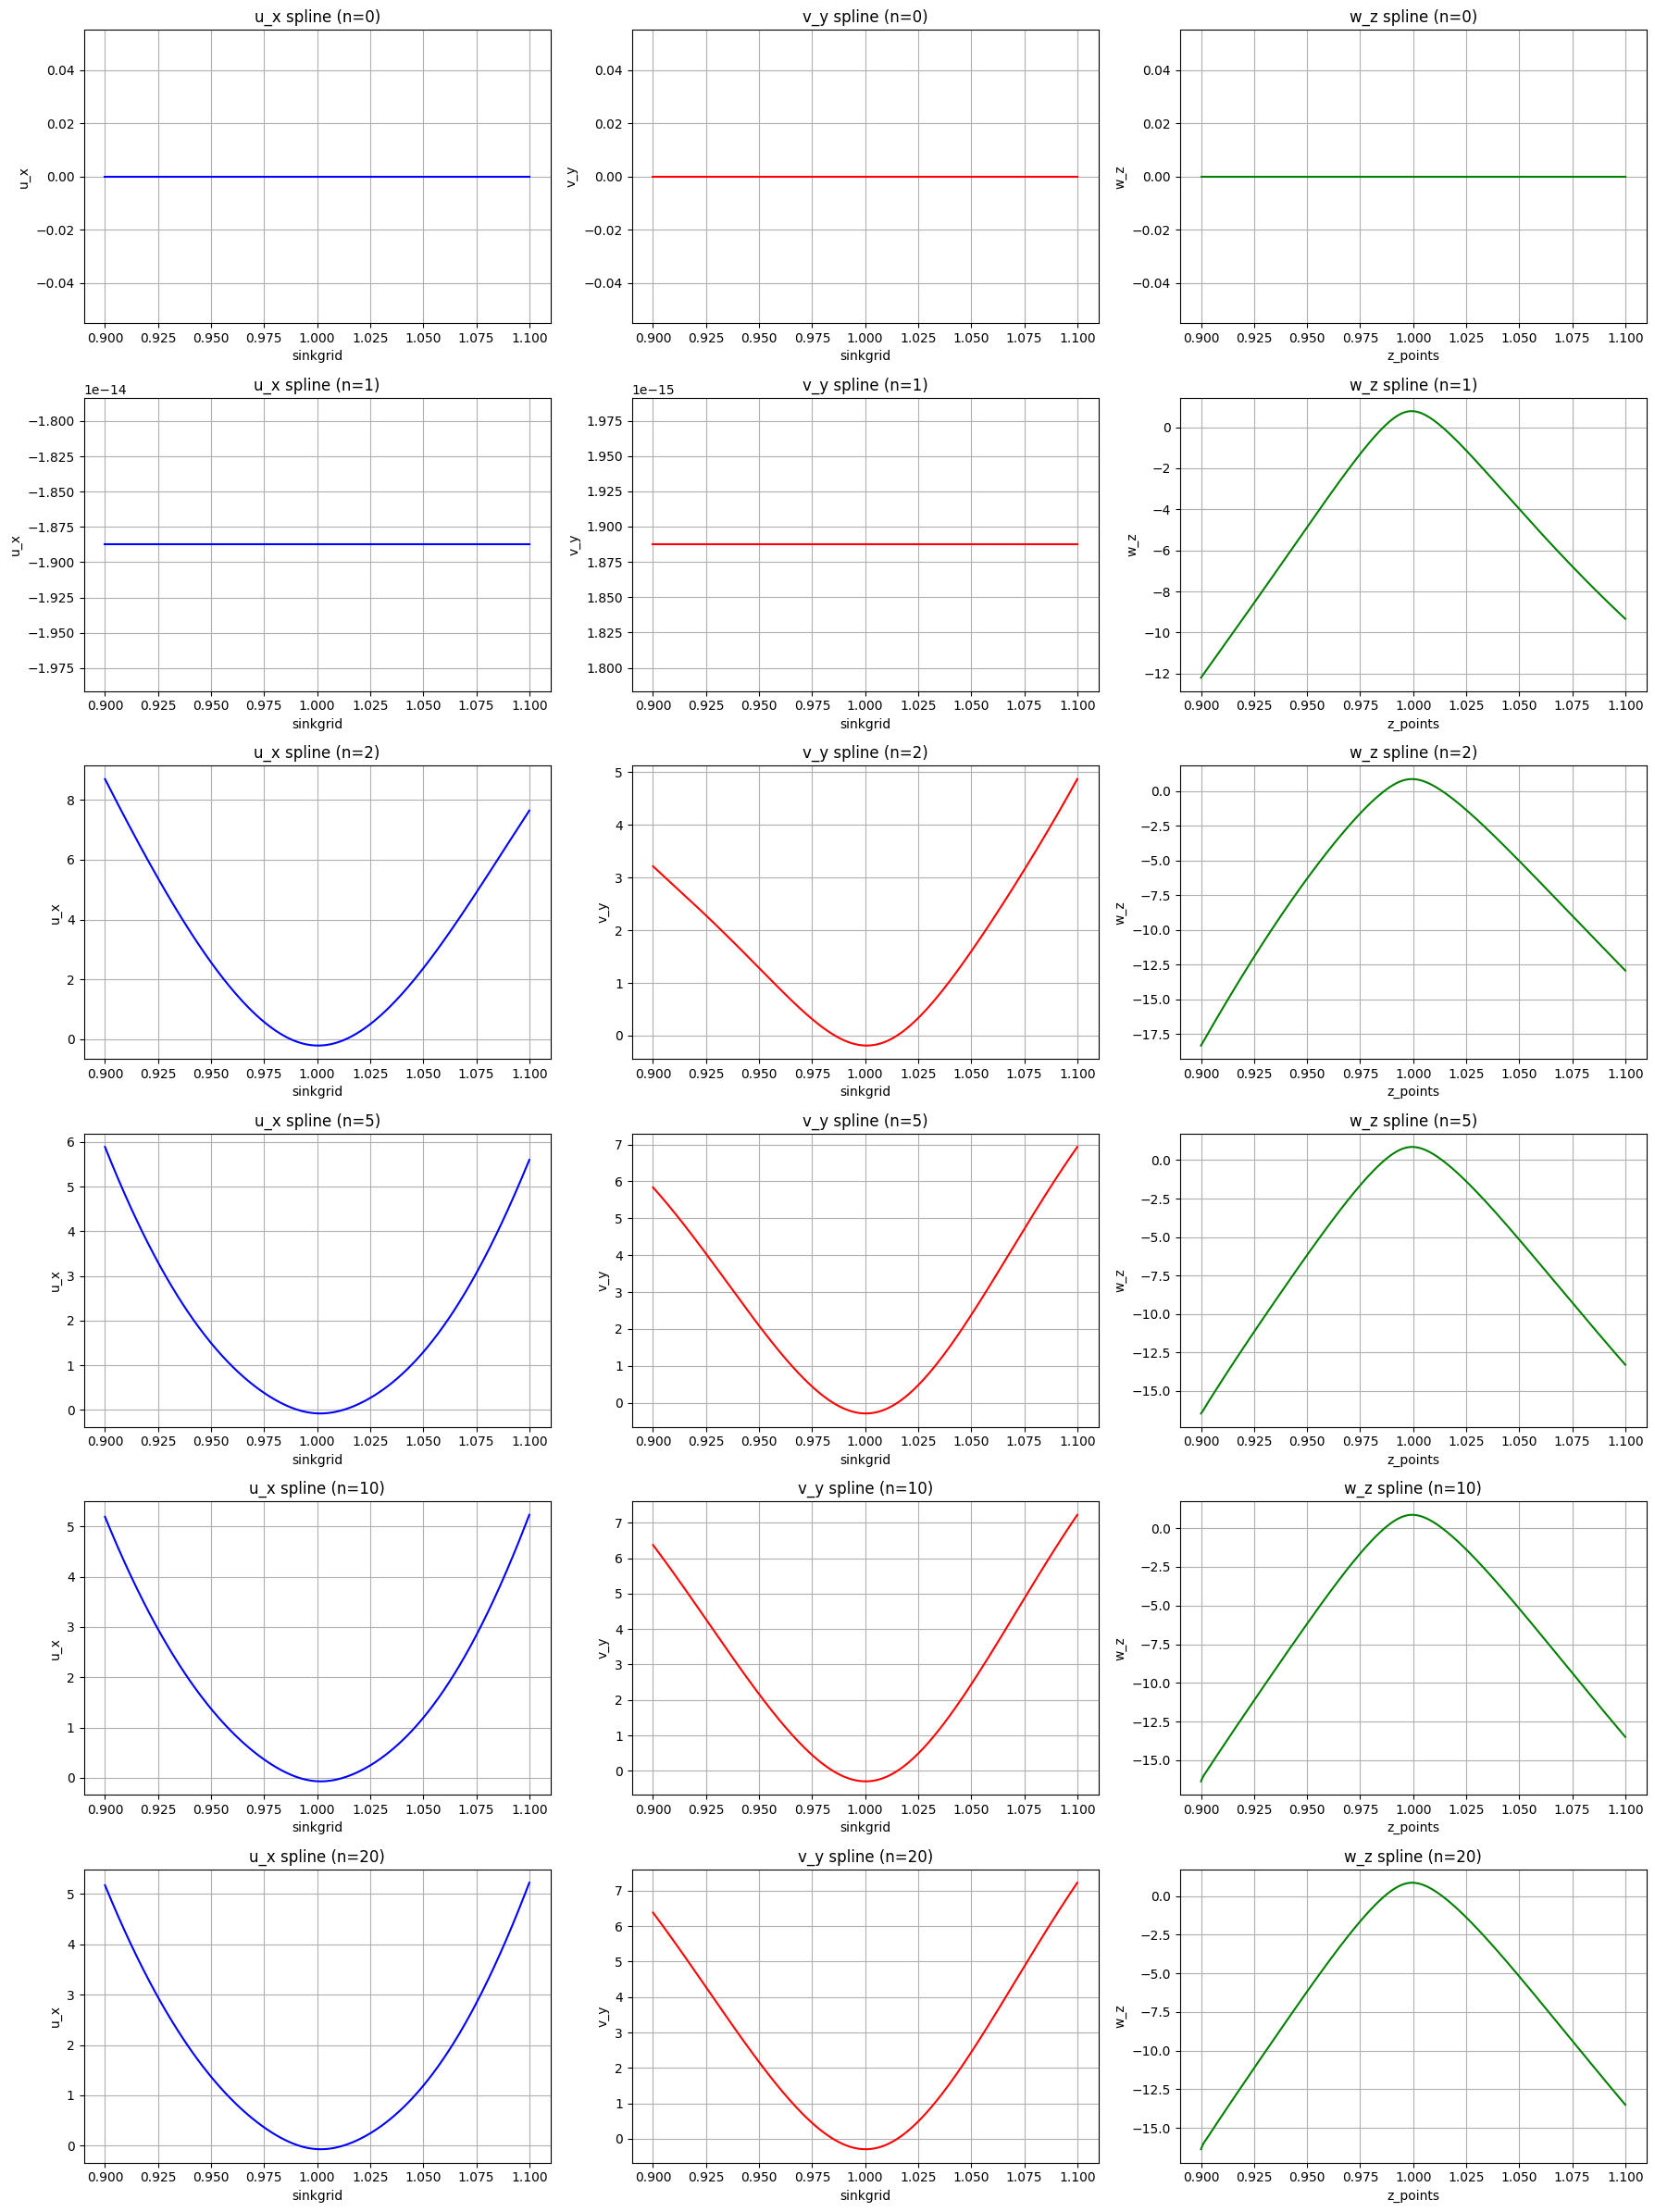

In [12]:
# --- Figure 1: Evolution of the splines in three columns ---

iterations_list = [0,1,2,5,10,20]
fig, axes = plt.subplots(len(iterations_list), 3, figsize=(18, 4 * len(iterations_list)))

for row_idx, n_iter in enumerate(iterations_list):
    opt_u, opt_v, opt_w = sinkhorn(sinkgrid, sinkweights, n_iter)
    u_spline = CubicSpline(sinkgrid, opt_u)
    v_spline = CubicSpline(sinkgrid, opt_v)
    w_spline = CubicSpline(z_points, opt_w)

    # Column 1: u_x spline
    ax_u = axes[row_idx, 0]
    ax_u.plot(quadgrid, u_spline(quadgrid), color='blue')
    ax_u.set_title(f'u_x spline (n={n_iter})')
    ax_u.set_xlabel('sinkgrid')
    ax_u.set_ylabel('u_x')
    ax_u.grid(True)

    # Column 2: v_y spline
    ax_v = axes[row_idx, 1]
    ax_v.plot(quadgrid, v_spline(quadgrid), color='red')
 
    ax_v.set_title(f'v_y spline (n={n_iter})')
    ax_v.set_xlabel('sinkgrid')
    ax_v.set_ylabel('v_y')
    ax_v.grid(True)

    # Column 3: w_z spline
    ax_w = axes[row_idx, 2]
    ax_w.plot(quadgrid, w_spline(quadgrid), color='green')

    ax_w.set_title(f'w_z spline (n={n_iter})')
    ax_w.set_xlabel('z_points')
    ax_w.set_ylabel('w_z')
    ax_w.grid(True)

plt.tight_layout()
plt.show()

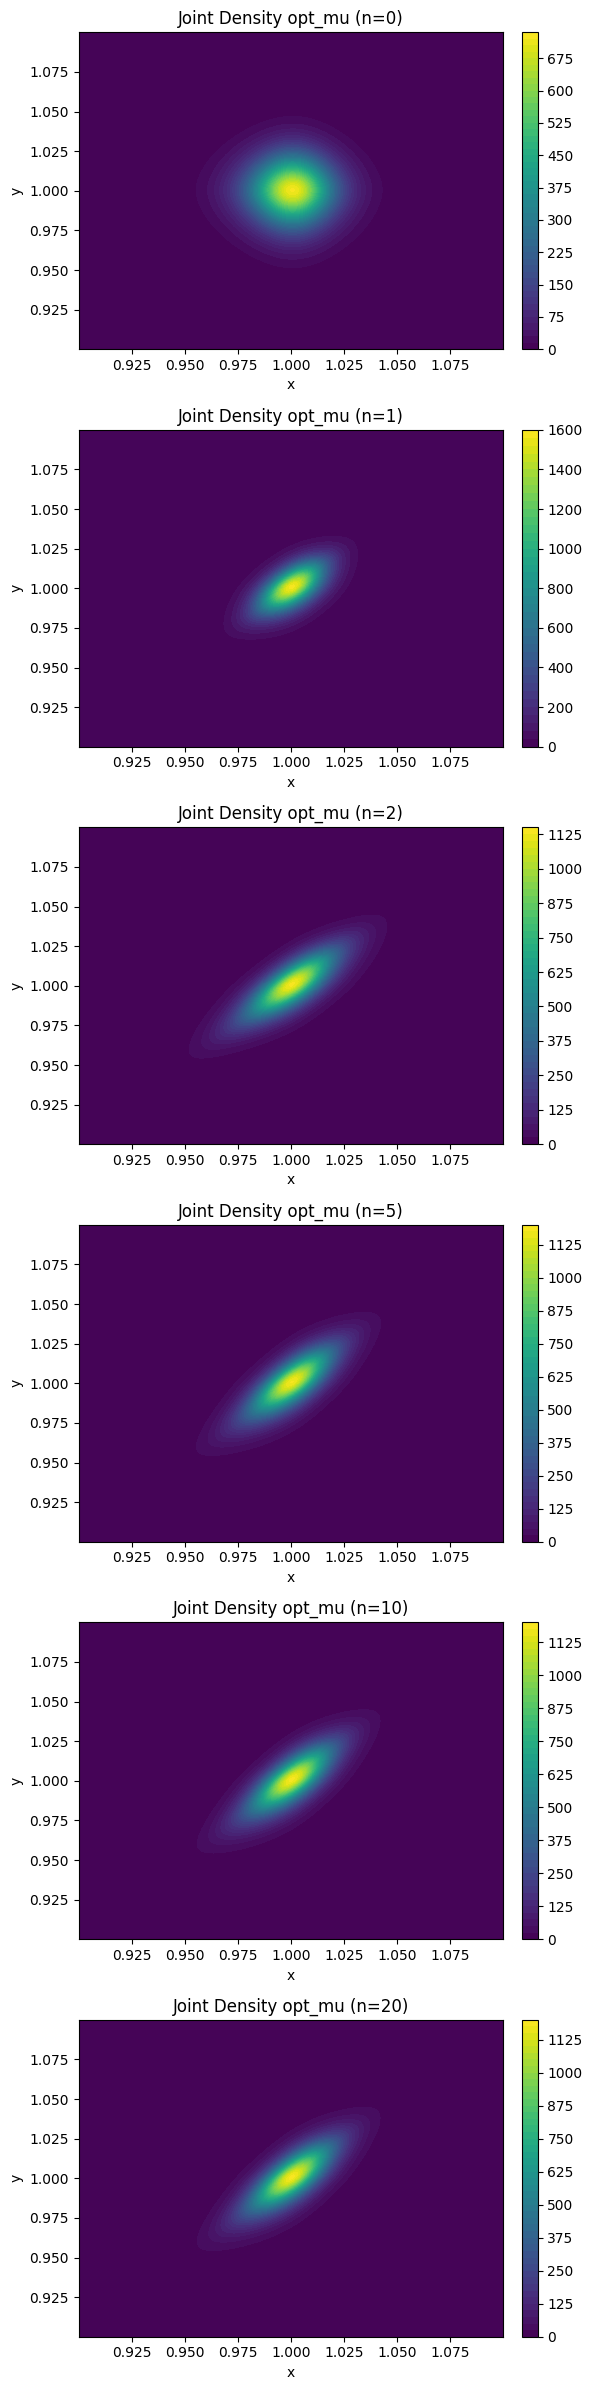

In [13]:
# --- Figure 2: Evolution of the joint density contour in one column ---

iterations_list = [0,1,2,5,10,20]

sinkPoints = 400
[u_s, w_s] = np.polynomial.legendre.leggauss(sinkPoints)
a_s = 0.8
b_s = 1.2
sinkgrid = 0.5*(b_s-a_s)*u_s + 0.5*(a_s+b_s)
sinkweights = 0.5*(b_s-a_s)*w_s
z_points = np.linspace(np.min(sinkgrid)/np.max(sinkgrid), np.max(sinkgrid)/np.min(sinkgrid), len(sinkgrid))

quadPoints = 400
[u, w] = np.polynomial.legendre.leggauss(quadPoints)
a = 0.9
b = 1.1
quadgrid = 0.5*(b-a)*u + 0.5*(a+b)
quadweights = 0.5*(b-a)*w


fig, axes = plt.subplots(len(iterations_list), 1, figsize=(6, 4 * len(iterations_list)))

for row_idx, n_iter in enumerate(iterations_list):
    opt_u, opt_v, opt_w = sinkhorn(sinkgrid, sinkweights, n_iter)
    u_spline = CubicSpline(sinkgrid, opt_u)
    v_spline = CubicSpline(sinkgrid, opt_v)
    w_spline = CubicSpline(z_points, opt_w)

    X, Y = np.meshgrid(quadgrid, quadgrid)
    Z = opt_mu(X, Y, u_spline, v_spline, w_spline)
    ax_c = axes[row_idx]
    contour = ax_c.contourf(X, Y, Z, levels=50, cmap='viridis')
    ax_c.set_title(f'Joint Density opt_mu (n={n_iter})')
    ax_c.set_xlabel('x')
    ax_c.set_ylabel('y')
    plt.colorbar(contour, ax=ax_c, orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [14]:
iterations_range = [0,10, 20, 30, 40, 50,60,70,80]
sinkPoints = 400
[u_s, w_s] = np.polynomial.legendre.leggauss(sinkPoints)
a_s = 0.8
b_s = 1.2
sinkgrid = 0.5 * (b_s - a_s) * u_s + 0.5 * (a_s + b_s)
sinkweights = 0.5 * (b_s - a_s) * w_s
z_points = np.linspace(np.min(sinkgrid) / np.max(sinkgrid),
                       np.max(sinkgrid) / np.min(sinkgrid),
                       len(sinkgrid))

# Store previous density
prev_density = None
density_diffs = []

# Create meshgrid for evaluating the density
X, Y = np.meshgrid(sinkgrid, sinkgrid)

for n_iter in iterations_range:
    opt_u, opt_v, opt_w = sinkhorn(sinkgrid, sinkweights, n_iter)

    # Reconstruct splines
    u_spline = CubicSpline(sinkgrid, opt_u)
    v_spline = CubicSpline(sinkgrid, opt_v)
    w_spline = CubicSpline(z_points, opt_w)

    # Evaluate the joint density
    current_density = opt_mu(X, Y, u_spline, v_spline, w_spline)

    if prev_density is not None:
        # Compute relative L2 norm difference
        diff = np.linalg.norm(current_density - prev_density) / np.linalg.norm(current_density)
        density_diffs.append(diff)
    else:
        density_diffs.append(np.nan)  # First iteration has no "previous" to compare

    prev_density = current_density.copy()

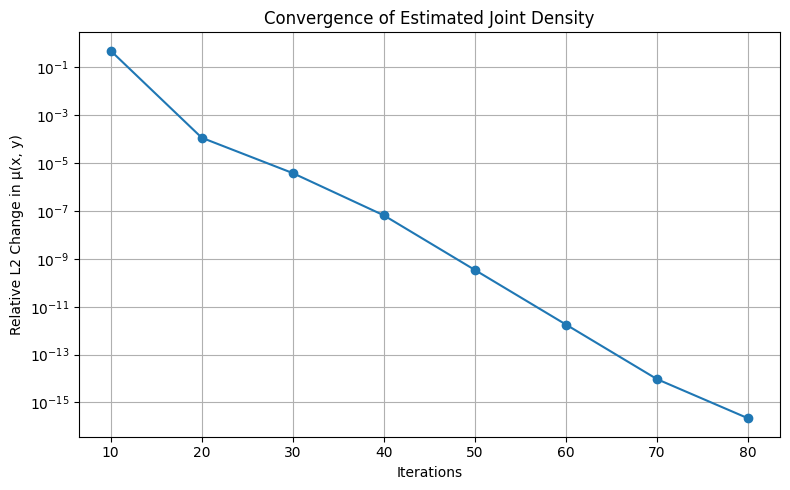

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(iterations_range, density_diffs, marker='o')
plt.yscale('log')
plt.xlabel("Iterations")
plt.ylabel("Relative L2 Change in μ(x, y)")
plt.title("Convergence of Estimated Joint Density")
plt.grid(True)
plt.tight_layout()
plt.show()

## Task 3

In [16]:
z_option_payoff = lambda x, y, k: np.maximum(0, x - y * k)
basket_payoff = lambda x, y,k: np.maximum(0.5 * (x + y) - k, 0)
quanto_payoff = lambda x, y,k: np.maximum(x / y - k, 0)
best_of_payoff = lambda x, y: np.maximum(x, y)
quadratic_payoff = lambda x, y: (x - y)**2

### Confirming that the joint density correctly prices options on Z

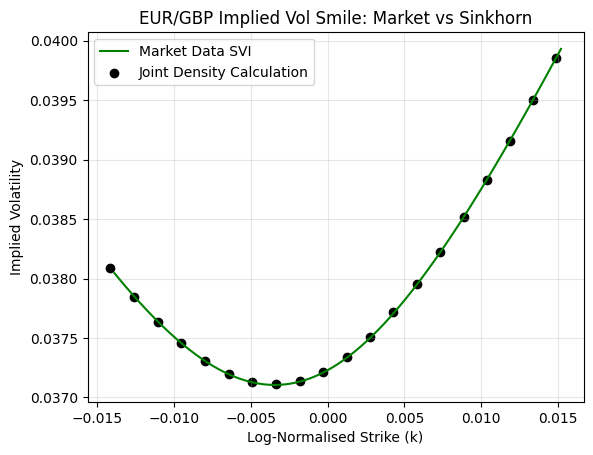

In [17]:
# Meshgrid over quadrature points
X, Y = np.meshgrid(quadgrid, quadgrid)
weights_2d = quadweights[:, np.newaxis] * quadweights[np.newaxis, :]
joint_density = opt_mu(X, Y, u_spline, v_spline, w_spline)

# Strikes
k_test = np.linspace(Z_norm[0],Z_norm[-1],20)

z_density_test_vol=np.zeros(len(k_test))

for i in range(len(k_test)):
    payoff_vals = z_option_payoff(X, Y, k_test[i])
    price = np.sum(payoff_vals * joint_density * weights_2d)*Z_forw
    z_density_test_vol[i]=implied_vol(Z_forw,k_test[i]*Z_forw,T,price)

# Vectorized payoff function
Z_strike_range = np.linspace(0.98*min(Z_strikes_lognrm), 1.02*max(Z_strikes_lognrm), 1000)
plt.plot(Z_strike_range, svi_vol(Z_strike_range,Zopt.x,T), color="green",label="Market Data SVI")
plt.scatter(np.log(k_test),z_density_test_vol,color="black",label="Joint Density Calculation")
plt.xlabel('Log-Normalised Strike (k)')
plt.ylabel('Implied Volatility')
plt.title('EUR/GBP Implied Vol Smile: Market vs Sinkhorn')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Computations of Exotics

In [19]:
basket_price= np.sum(basket_payoff(X,Y,1) * joint_density * weights_2d)
quanto_price=np.sum(quanto_payoff(X,Y,1) * joint_density * weights_2d)
best_of_price=np.sum(best_of_payoff(X,Y) * joint_density * weights_2d)
quadratic_price=np.sum(quadratic_payoff(X,Y) * joint_density * weights_2d)


print(f"{'Payoff Type':<25}{'Price':>15}")
print("-" * 40)
print(f"{'Basket option (k=1)':<25}{basket_price:>15.6f}")
print(f"{'Quanto option (k=1)':<25}{quanto_price:>15.6f}")
print(f"{'Best-of option':<25}{best_of_price:>15.6f}")
print(f"{'Quadratic payoff':<25}{quadratic_price:>15.6f}")


Payoff Type                        Price
----------------------------------------
Basket option (k=1)             0.005886
Quanto option (k=1)             0.004331
Best-of option                  1.004284
Quadratic payoff                0.000122


### Comparison against Monte Carlo Techniques